# 1D wave equation

Written by Ali A. Eftekhari

Last checked: June 2021

Ported to Python by Gavin M. Weir, June 2023

### PDE and boundary conditions
The homogeneous wave equation reads

 $$\frac{\partial^2 c}{\partial t^2} = u^2 \frac{\partial^2 c}{\partial x^2},$$

 where $c$ is the independent variable (displacement, concentration, temperature, etc)
 , $u$ is the characteristic velocity.
 
 The inhomogeneous wave equation with initial conditions on the value and derivative of the concentration takes the form 
 
 \begin{align}
     & \frac{\partial^2 c\left(x,t\right)}{\partial t^2} - u^2 \frac{\partial^2 c\left(x,t\right)}{\partial x^2} = s\left(x,t\right) \\
     & c\left(x, 0\right) = f\left(x\right) \\
     & \frac{\partial c}{\partial t}\left(x, 0\right) = g\left(x\right)
 \end{align}
 



In [1]:
import pyfvtool as pf
import numpy as np

# for animation and visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# c=@(x)(x.^2);
# dc=@(x)(2*x);

def c(x):
    return x*x

def dc(x):
    return 2.0*x


Lx = float(1.0)   # length of domain
Nx = int(200)     # number of cells in domain
dx = Lx/Nx        # step-size in uniform 1d grid
m = pf.createMesh1D(Nx, Lx) # 1D domain

x_face=m.facecenters.x   # face positions
x_cell=m.cellcenters.x   # node positions

# Boundary conditions
BC = pf.createBC(m)
BC.left.periodic = True
BC.right.periodic = True

# initial value on grid
u0 = np.abs(np.sin(x_cell/Lx*10*np.pi))

# Velocity on grid nodes (cell centers)
u_old = pf.createCellVariable(m, u0);
u_val = u_old

dt = 0.1  # time-step for calculations

# Initialize the face concenrtation values and their derivatives at the faces 
c_face = pf.createFaceVariable(m, 0.0)     # concentration values
c_face.xvalue = c(x_face)                         
dc_cell = pf.createCellVariable(m, dc(x_cell))  # concentration derivative

# Convection and inhomogeneity act as sources
Mconv = pf.convectionUpwindTerm(c_face)
Ms = pf.linearSourceTerm(dc_cell)            # 

Mbc, RHSbc = pf.boundaryConditionTerm(BC)

# ========= #

ui = []
for ii in range(2000): # 1:1000
    Mt, RHSt = pf.transientTerm(u_old, dt, 1.0)
    
    # Coefficient matrix
    M = Mt+Mconv-Ms+Mbc   # transient term + convection - linear source + value at boundary
    
    # Define right-hand side of the equation
    RHS = RHSt+RHSbc   # right-hand side is the time-derivative + boundary condition (source terms)
    
    # Solve the PDE 
    ui.append(pf.solvePDE(m, M, RHS) )
    
    # Downgrade the current solution to a previous time-step
    u_old = ui[ii]
    # visualizeCells(ui[ii])

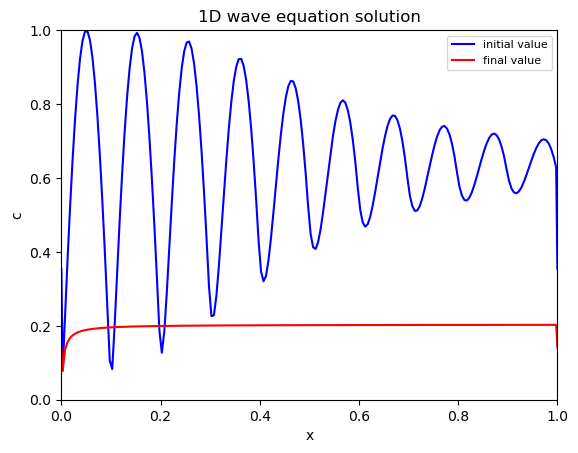

In [3]:
# Plotting and visualization of the 1D wave equation solution  

hfig1, ax1 = plt.subplots()

xx, uu = pf.get_CellVariable_profile1D(ui[0])
ax1.plot(xx, uu, 'b-', label='initial value')

xx, uu = pf.get_CellVariable_profile1D(ui[-1])
ax1.plot(xx, uu, 'r-', label='final value')

ax1.set_xlim((0, Lx))
ax1.set_ylim((0.0, 1.0))

ax1.set_xlabel('x')
ax1.set_ylabel('c')
ax1.set_title('1D wave equation solution')
ax1.legend(fontsize=8);